In [1]:
%pwd

'd:\\ML\\LiveProject\\ML-CreditCardDefaulter\\research'

In [3]:
import os

In [4]:
os.chdir('../')

In [5]:
%pwd

'd:\\ML\\LiveProject\\ML-CreditCardDefaulter'

In [6]:
from dataclasses import dataclass
from pathlib import Path
@dataclass(frozen=True)
class ModelTrainerConfig:
    root_dir: Path
    train_data_path: Path
    model_kmeans_name: str
    model_xabost_name: str
    elbow_png:Path
    param_grid:dict
    param_grid_xgboost: dict
    model_dir: Path

In [7]:
from ml_creditcard_defaulter.constants import *
from ml_creditcard_defaulter.utils.common import read_yaml, create_directories

In [8]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH,
        schema_filepath = SCHEMA_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)

        create_directories([self.config.artifacts_root])

    def get_model_trainer_config(self) -> ModelTrainerConfig:
        config = self.config.model_trainer
        params = self.params
        params.param_grid["var_smoothing"] = [float(v) for v in params.param_grid["var_smoothing"]]
        # schema =  self.schema.TARGET_COLUMN

        create_directories([config.root_dir, config.model_dir])

        model_trainer_config = ModelTrainerConfig(
            root_dir=config.root_dir,
            train_data_path = config.train_data_path,
            model_kmeans_name = config.model_kmeans_name,
            model_xabost_name = config.model_xabost_name,
            elbow_png=config.elbow_png,
            param_grid=params.param_grid,
            param_grid_xgboost=params.param_grid_xgboost,
            model_dir=config.model_dir,
        )

        return model_trainer_config

In [9]:
import os
import urllib.request as request
import zipfile
from ml_creditcard_defaulter import logger
from ml_creditcard_defaulter.components.data_transformation import DataTransformation

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.linear_model import ElasticNet
import joblib
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics  import roc_auc_score,accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [11]:
class ModelTrainer:
    def __init__(self, config: ModelTrainerConfig):
        self.config = config

    def elbow_plot(self, data):

        logger.info('Entered the elbow_plot method of the KMeansClustering class')
        wcss=[] # initializing an empty list
        try:
            for i in range (1,11):
                kmeans=KMeans(n_clusters=i,init='k-means++',random_state=42) # initializing the KMeans object
                kmeans.fit(data) # fitting the data to the KMeans Algorithm
                wcss.append(kmeans.inertia_)
            plt.plot(range(1,11),wcss) # creating the graph between WCSS and the number of clusters
            plt.title('The Elbow Method')
            plt.xlabel('Number of clusters')
            plt.ylabel('WCSS')
            #plt.show()
            plt.savefig(self.config.elbow_png) # saving the elbow plot locally
            # finding the value of the optimum cluster programmatically
            kn = KneeLocator(range(1, 11), wcss, curve='convex', direction='decreasing')
            logger.info( 'The optimum number of clusters is: '+str(kn.knee)+' . Exited the elbow_plot method of the KMeansClustering class')
            return kn.knee

        except Exception as e:
            logger.info('Exception occured in elbow_plot method of the KMeansClustering class. Exception message:  ' + str(e))
            logger.info('Finding the number of clusters failed. Exited the elbow_plot method of the KMeansClustering class')
            raise Exception()

    def create_clusters(self,data,number_of_clusters):
        logger.info( 'Entered the create_clusters method of the KMeansClustering class')
        try:
            kmeans = KMeans(n_clusters=number_of_clusters, init='k-means++', random_state=42)
            #self.data = self.data[~self.data.isin([np.nan, np.inf, -np.inf]).any(1)
            y_kmeans=kmeans.fit_predict(data) #  divide data into clusters

            joblib.dump(kmeans, os.path.join(self.config.root_dir, self.config.model_kmeans_name)) # saving the KMeans model to directory
                                                                                    # passing 'Model' as the functions need three parameters
            data['Cluster']=y_kmeans  # create a new column in dataset for storing the cluster information
            logger.info( 'succesfully created clusters. Exited the create_clusters method of the KMeansClustering class')
            return data
        except Exception as e:
            logger.info('Exception occured in create_clusters method of the KMeansClustering class. Exception message:  ' + str(e))
            logger.info('Fitting the data to clusters failed. Exited the create_clusters method of the KMeansClustering class')
            raise Exception()
        
    def get_best_params_for_naive_bayes(self,train_x,train_y):
        logger.info( 'Entered the get_best_params_for_naive_bayes method of the Model_Finder class')
        try:
            # initializing with different combination of parameters
            # param_grid = {"var_smoothing": [1e-9,0.1, 0.001, 0.5,0.05,0.01,1e-8,1e-7,1e-6,1e-10,1e-11]}
            print(self.config.param_grid)
            param_grid = self.config.param_grid
            #Creating an object of the Grid Search class
            gnb =GaussianNB()
            grid = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=3,  verbose=3)
            #finding the best parameters
            grid.fit(train_x, train_y)

            #extracting the best parameters
            var_smoothing = grid.best_params_['var_smoothing']


            #creating a new model with the best parameters
            gnb = GaussianNB(var_smoothing=var_smoothing)
            # training the mew model
            gnb.fit(train_x, train_y)
            logger.info('Naive Bayes best params: '+str(grid.best_params_)+'. Exited the get_best_params_for_naive_bayes method of the Model_Finder class')

            return gnb
        except Exception as e:
            logger.info('Exception occured in get_best_params_for_naive_bayes method of the Model_Finder class. Exception message:  ' + str(e))
            logger.info('Naive Bayes Parameter tuning  failed. Exited the get_best_params_for_naive_bayes method of the Model_Finder class')
            raise Exception()
        
    def get_best_params_for_xgboost(self,train_x,train_y):
        logger.info('Entered the get_best_params_for_xgboost method of the Model_Finder class')
        try:
            # initializing with different combination of parameters
            # param_grid_xgboost = {"n_estimators": [50,100, 130],"max_depth": range(3, 11, 1),"random_state":[0,50,100]}
            param_grid_xgboost = self.config.param_grid_xgboost
            # Creating an object of the Grid Search class
            grid= GridSearchCV(XGBClassifier(objective='binary:logistic'),param_grid_xgboost, verbose=3,cv=2,n_jobs=-1)
            # finding the best parameters
            grid.fit(train_x, train_y)

            # extracting the best parameters
            random_state = grid.best_params_['random_state']
            max_depth = grid.best_params_['max_depth']
            n_estimators = grid.best_params_['n_estimators']

            # creating a new model with the best parameters
            xgb = XGBClassifier(random_state=random_state, max_depth=max_depth,n_estimators= n_estimators, n_jobs=-1 )
            # training the mew model
            xgb.fit(train_x, train_y)
            logger.info('XGBoost best params: ' + str(
                                       grid.best_params_) + '. Exited the get_best_params_for_xgboost method of the Model_Finder class')
            return xgb
        except Exception as e:
            logger.info('Exception occured in get_best_params_for_xgboost method of the Model_Finder class. Exception message:  ' + str(e))
            logger.info('XGBoost Parameter tuning  failed. Exited the get_best_params_for_xgboost method of the Model_Finder class')
            raise Exception()
        
    def get_best_model(self,train_x,train_y,test_x,test_y):

        logger.info('Entered the get_best_model method of the Model_Finder class')
        # create best model for XGBoost
        try:
            xgboost= self.get_best_params_for_xgboost(train_x,train_y)
            prediction_xgboost =xgboost.predict(test_x) # Predictions using the XGBoost Model

            if len(test_y.unique()) == 1: #if there is only one label in y, then roc_auc_score returns error. We will use accuracy in that case
                xgboost_score = accuracy_score(test_y, prediction_xgboost)
                logger.info( 'Accuracy for XGBoost:' + str(xgboost_score))  # Log AUC
            else:
                xgboost_score = roc_auc_score(test_y, prediction_xgboost) # AUC for XGBoost
                logger.info( 'AUC for XGBoost:' + str(xgboost_score)) # Log AUC

            # create best model for Random Forest
            naive_bayes=self.get_best_params_for_naive_bayes(train_x,train_y)
            prediction_naive_bayes=naive_bayes.predict(test_x) # prediction using the Random Forest Algorithm

            if len(test_y.unique()) == 1:#if there is only one label in y, then roc_auc_score returns error. We will use accuracy in that case
                naive_bayes_score = accuracy_score(test_y,prediction_naive_bayes)
                logger.info( 'Accuracy for NB:' + str(naive_bayes_score))
            else:
                naive_bayes_score = roc_auc_score(test_y,prediction_naive_bayes) # AUC for Random Forest
                logger.info( 'AUC for RF:' + str(naive_bayes_score))

            #comparing the two models
            if(naive_bayes_score <  xgboost_score):
                return 'XGBoost',xgboost
            else:
                return 'NaiveBayes',naive_bayes

        except Exception as e:
            logger.info('Exception occured in get_best_model method of the Model_Finder class. Exception message:  ' + str(e))
            logger.info('Model Selection Failed. Exited the get_best_model method of the Model_Finder class')
            raise Exception()
        
    def train(self):
        train_data = pd.read_csv(self.config.train_data_path)
        test_data = pd.read_csv(self.config.test_data_path)


        train_x = train_data.drop([self.config.target_column], axis=1)
        test_x = test_data.drop([self.config.target_column], axis=1)
        train_y = train_data[[self.config.target_column]]
        test_y = test_data[[self.config.target_column]]


        lr = ElasticNet(alpha=self.config.alpha, l1_ratio=self.config.l1_ratio, random_state=42)
        lr.fit(train_x, train_y)

        joblib.dump(lr, os.path.join(self.config.root_dir, self.config.model_name))

  

[2025-01-26 10:59:49,673: INFO: common: yaml file: config\config.yaml loaded successfully]
[2025-01-26 10:59:49,682: INFO: common: yaml file: params.yaml loaded successfully]
[2025-01-26 10:59:49,687: INFO: common: yaml file: schema.yaml loaded successfully]
[2025-01-26 10:59:49,689: INFO: common: created directory at: artifacts]
[2025-01-26 10:59:49,691: INFO: common: created directory at: artifacts/model_trainer]
[2025-01-26 10:59:49,692: INFO: common: created directory at: artifacts/model_trainer/models]
[2025-01-26 10:59:49,798: INFO: 2685296005: Entered the elbow_plot method of the KMeansClustering class]
[2025-01-26 10:59:50,719: INFO: 2685296005: The optimum number of clusters is: 3 . Exited the elbow_plot method of the KMeansClustering class]
[2025-01-26 10:59:50,719: INFO: 2685296005: Entered the create_clusters method of the KMeansClustering class]
[2025-01-26 10:59:50,771: INFO: 2685296005: succesfully created clusters. Exited the create_clusters method of the KMeansClusteri

c:\Users\Sharif\anaconda3\envs\ml\lib\site-packages\numpy\ma\core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[2025-01-26 11:00:12,772: INFO: 2685296005: XGBoost best params: {'max_depth': 3, 'n_estimators': 50, 'random_state': 0}. Exited the get_best_params_for_xgboost method of the Model_Finder class]
[2025-01-26 11:00:12,808: INFO: 2685296005: AUC for XGBoost:0.5480784835805756]
[2025-01-26 11:00:12,808: INFO: 2685296005: Entered the get_best_params_for_naive_bayes method of the Model_Finder class]
{'var_smoothing': [1e-09, 0.1, 0.001, 0.5, 0.05, 0.01, 1e-08, 1e-07, 1e-06, 1e-10, 1e-11]}
Fitting 3 folds for each of 11 candidates, totalling 33 fits
[CV 1/3] END ...............var_smoothing=1e-09;, score=0.635 total time=   0.0s
[CV 2/3] END ...............var_smoothing=1e-09;, score=0.708 total time=   0.0s
[CV 3/3] END ...............var_smoothing=1e-09;, score=0.747 total time=   0.0s
[CV 1/3] END .................var_smoothing=0.1;, score=0.703 total time=   0.0s
[CV 2/3] END .................var_smoothing=0.1;, score=0.736 total time=   0.0s
[CV 3/3] END .................var_smoothing=0.

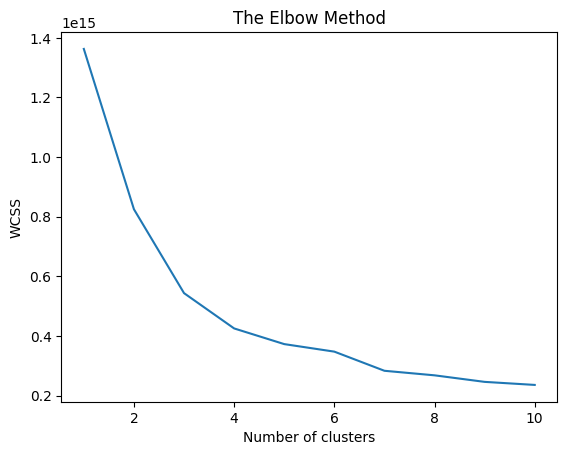

In [12]:
try:
    config = ConfigurationManager()
    model_training_config = config.get_model_trainer_config()
    model_training = ModelTrainer(config=model_training_config)
    data_transformation = DataTransformation(config=model_training_config)
    data = pd.read_csv(model_training_config.train_data_path)

    X = data.drop(['Labels'], axis=1)
    number_of_clusters = model_training.elbow_plot(X)
    xy = X.copy()
    X = model_training.create_clusters(X, number_of_clusters)
    
    X['Labels'] = data['Labels']
    list_of_clusters=X['Cluster'].unique()

    for i in list_of_clusters:
        cluster_data=X[X['Cluster']==i] # filter the data for one cluster

                # Prepare the feature and Label columns
        cluster_features=cluster_data.drop(['Labels','Cluster'],axis=1)
        cluster_label= cluster_data['Labels']

                # splitting the data into training and test set for each cluster one by one
        x_train, x_test, y_train, y_test = train_test_split(cluster_features, cluster_label, test_size=1 / 3, random_state=355)
                # Proceeding with more data pre-processing steps
        train_x = data_transformation.scale_numerical_columns(x_train)
        test_x = data_transformation.scale_numerical_columns(x_test)
        best_model_name,best_model=model_training.get_best_model(train_x,y_train,test_x,y_test)
        print('......................................' )
        joblib.dump(best_model, os.path.join(model_training_config.model_dir, best_model_name+str(i)+'.pkl'))
        logger.info(f'Successful End of Training with best model {best_model_name+str(i)}')
except Exception as e:
    raise e

In [30]:
config = ConfigurationManager()
model_training_config = config.get_model_trainer_config()
train_data = pd.read_csv(model_training_config.train_data_path)

[2025-01-24 19:20:08,908: INFO: common: yaml file: config\config.yaml loaded successfully]
[2025-01-24 19:20:08,911: INFO: common: yaml file: params.yaml loaded successfully]
[2025-01-24 19:20:08,913: INFO: common: yaml file: schema.yaml loaded successfully]
[2025-01-24 19:20:08,920: INFO: common: created directory at: artifacts]
[2025-01-24 19:20:08,923: INFO: common: created directory at: artifacts/model_trainer]


In [31]:
train_data

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Labels
0,30000,2,3,1,36,1,2,-1,2,2,...,4789,3597,21234,22,6245,3,6,30006,1221,0
1,20000,2,2,1,25,2,2,2,2,0,...,11207,6720,5071,1500,1005,0,511,1283,0,1
2,480000,2,3,1,36,-1,0,0,-1,-1,...,7331,7000,7000,1368,1000,7331,7000,7000,7000,0
3,30000,2,3,1,43,1,2,0,0,0,...,23352,18738,15236,0,1468,1564,591,489,388,0
4,200000,2,1,2,34,1,-2,-2,-2,-2,...,-2113,-2113,-2113,0,0,0,0,0,423,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22495,30000,1,2,2,24,-1,-1,-1,0,0,...,780,0,0,390,780,0,0,0,0,1
22496,90000,2,3,1,25,0,0,0,0,0,...,8718,6432,2655,1619,1266,1048,1032,1655,0,0
22497,110000,2,2,2,24,1,2,0,0,0,...,48720,48540,43692,0,3200,2478,2000,1900,2000,0
22498,230000,2,3,1,32,0,0,0,0,0,...,94814,98182,98457,5000,5000,5000,5000,4000,5000,0


In [37]:
{'param_grid': {'var_smoothing': ['1e-9', 0.1, 0.001, 0.5, 0.05, 0.01, '1e-8', '1e-7', '1e-6', '1e-10', '1e-11']}}

In [37]:
data1.head()

""


In [13]:
len(X.columns)

25

In [14]:
X.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'Labels',
       'Cluster'],
      dtype='object')

In [18]:
X = X.drop(['Labels'], axis=1)

In [19]:
X

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Cluster
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,1
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,1
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,1,3,1,39,0,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,150000,1,3,2,43,-1,-1,-1,-1,0,...,8979,5190,0,1837,3526,8998,129,0,0,1
29997,30000,1,2,2,37,4,3,2,-1,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,80000,1,3,1,41,1,-1,0,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1
